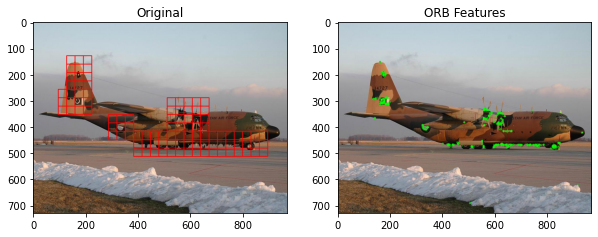

In [1]:
import cv2
import matplotlib.pyplot as plt

# ---------------------------
# 1. Image Loading 
# ---------------------------
img_path = 'c130.jpg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  

# Check if the image exists
if img is None:
    print("Error loading image. Check the file path.")
    exit()

# Convert to grayscale (ORB works better on grayscale)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------------------------
# 2. Feature Detection (ORB)
# ---------------------------
orb = cv2.ORB_create()

# Detect keypoints
keypoints = orb.detect(img_gray, None)

# Compute descriptors (optional, helpful for matching features)
keypoints, descriptors = orb.compute(img_gray, keypoints)

# Draw detected keypoints on the image
img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=0)

# ---------------------------
# 3. Sliding Window 
# ---------------------------
window_size = (64, 64)  # Example window size
step_size = 32  # Step size for moving the window

for y in range(0, img_gray.shape[0], step_size):
    for x in range(0, img_gray.shape[1], step_size):
        # Extract the window region
        window = img_gray[y:y + window_size[0], x:x + window_size[1]]

        # Process the window (here, we simply count features)
        window_keypoints = [kp for kp in keypoints if kp.pt[0] >= x and kp.pt[0] < x + window_size[0]
                                                 and kp.pt[1] >= y and kp.pt[1] < y + window_size[1]]
        num_features = len(window_keypoints)

        # Do something with this information (e.g., highlight regions with many features)
        if num_features > 10:  # Arbitrary threshold
            cv2.rectangle(img, (x, y), (x + window_size[0], y + window_size[1]), (0, 0, 255), 2)

# ---------------------------
# 4. Visualization
# ---------------------------
plt.figure(figsize=(10, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)), plt.title('ORB Features')
plt.show()


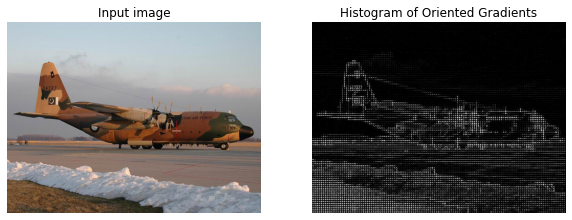

In [4]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# ---------------------------
# 1. Image Loading 
# ---------------------------
img_path = 'c130.jpg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  

# Check if the image exists
if img is None:
    print("Error loading image. Check the file path.")
    exit()

# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------------------------
# 2. HOG Feature Computation
# ---------------------------
fd, hog_image = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

# ---------------------------
# 3. Visualization
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray), ax2.set_title('Histogram of Oriented Gradients')
plt.show()


<ipython-input-27-29cd8f1e71cb>:42: RuntimeWarning: invalid value encountered in divide
  cell_mag = cell_mag / np.linalg.norm(cell_mag) + 1e-5  # Avoid division by zero


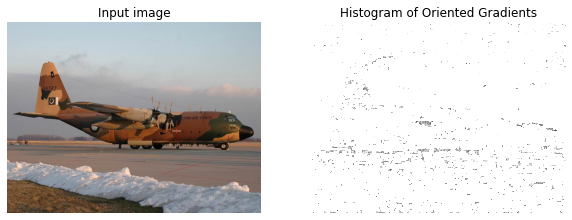

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# Re-define the custom HOG function
def custom_hog(image):
    # Calculate gradients
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # Orientation binning
    bins = np.linspace(0, 180, orientations, endpoint=False) 
    cell_hist = np.zeros((image.shape[0] // pixels_per_cell[0], 
                          image.shape[1] // pixels_per_cell[1], 
                          orientations))
    for i in range(cell_hist.shape[0]):
        for j in range(cell_hist.shape[1]):
            cell_mag = mag[i * pixels_per_cell[0]: (i + 1) * pixels_per_cell[0],
                           j * pixels_per_cell[1]: (j + 1) * pixels_per_cell[1]]
            cell_ang = angle[i * pixels_per_cell[0]: (i + 1) * pixels_per_cell[0],
                             j * pixels_per_cell[1]: (j + 1) * pixels_per_cell[1]]
            hist = np.histogram(cell_ang, bins=np.append(bins, 180), weights=cell_mag)[0]

            cell_hist[i, j, :] = hist  # Fill the histogram for each cell

    # Block normalization
    hog_features = []
    for i in range(cell_hist.shape[0] - cells_per_block[0] + 1):
        for j in range(cell_hist.shape[1] - cells_per_block[1] + 1):
            block = cell_hist[i:i + cells_per_block[0], j:j + cells_per_block[1], :]
            block_norm = np.linalg.norm(block, axis=2, keepdims=True) + 1e-5  # Avoid division by zero
            normalized_block = block / block_norm
            hog_features.extend(normalized_block.ravel())

    # Visualization
    hog_image = np.zeros((image.shape[0], image.shape[1]))
    for i in range(cell_hist.shape[0]):
        for j in range(cell_hist.shape[1]):
            cell_mag = cell_hist[i, j, :]
            cell_mag = cell_mag / np.linalg.norm(cell_mag) + 1e-5  # Avoid division by zero
            hog_image[i * pixels_per_cell[0]:(i + 1) * pixels_per_cell[0],
                      j * pixels_per_cell[1]:(j + 1) * pixels_per_cell[1]] = cell_mag.max()

    return np.array(hog_features), hog_image

# Load the image
img_path = 'c130.jpg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

# Convert to grayscale and compute HOG features
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the parameters for HOG feature computation
orientations = 15
pixels_per_cell = (2, 2)
cells_per_block = (2, 2)
hog_features, hog_image = custom_hog(img_gray)

# Rescale the HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Create figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

# Show
# Show original image
ax1.axis('off')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Input image')

# Show HOG image
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


# Semantic Segmentation

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision.models as models
import torchvision.transforms as T

# 1. Load the image
image_path = "c130.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB

# 2. Convert NumPy array to PIL Image
image = Image.fromarray(image)  

# 3. Preprocess the image 
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)


# 3. Load a pre-trained model
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()  # Set model to evaluation mode

# 4. Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0] # Get the model's output

# 5.  Create the segmentation mask
output_predictions = output.argmax(0)  # Get the predicted class for each pixel
# Let's say your image only has classes 0, 1, and 5 present
palette = torch.tensor([[0, 0, 128], # Background (blue)
            [0, 255, 0], # Aircraft body (green)
            [255, 0, 0], # Wings (red)
            [0, 0, 255]]) # Engines (purple)


colors = palette.repeat_interleave(224 * 224, dim=0)  # Adjust view to match mask dimensions
boolean_mask = output_predictions.reshape(224, 224).bool()    
colored_mask = torch.zeros((224, 224, 3), dtype=torch.uint8) # Initialize empty mask 
colored_mask[boolean_mask] = colors  #  Assign colors where  the mask evaluates to 'True'
colored_mask = colored_mask.permute(1, 2, 0) 



# 6. Visualize the results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(colored_mask.numpy())
ax2.set_title('Semantic Segmentation')
ax2.axis('off')

plt.show()


RuntimeError: shape mismatch: value tensor of shape [200704, 3] cannot be broadcast to indexing result of shape [10716, 3]

In [1]:
import pycrfsuite
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Load the image
image = io.imread('c130.jpg')  

# Prepare features (replace with your feature extraction logic)
# Here, we'll use simple pixel intensities and coordinates
X = np.dstack([image, 
               np.tile(np.arange(image.shape[0])[:, np.newaxis], (1, image.shape[1])),
               np.tile(np.arange(image.shape[1])[np.newaxis, :], (image.shape[0], 1))])

# Prepare features (with string conversion)
X_str = []
for row in X:
    row_str = [str(feature) for feature in row]
    X_str.append(row_str)

# Prepare labels in the correct format
y_seq = [list(row) for row in y]  

# Train the CRF model
trainer = pycrfsuite.Trainer(verbose=False)
for xseq, yseq in zip(X_str, y_seq):
    trainer.append(xseq, yseq)
trainer.train('your_crf_model.crfsuite')


# Load the trained model
tagger = pycrfsuite.Tagger()
tagger.open('your_crf_model.crfsuite')

# Perform inference
predicted_labels = tagger.tag(X)
predicted_image = np.reshape(predicted_labels, image.shape[:2]) 

# Visualize results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(predicted_image)
plt.title('CRF Segmentation')
plt.show()


NameError: name 'y' is not defined

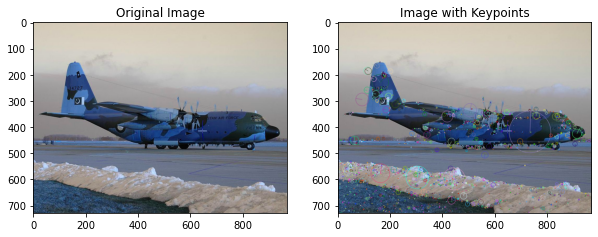

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load the image (make sure you have c130.jpg in the same directory)
img = cv2.imread('c130.jpg')

# Convert to grayscale for feature detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create a SIFT detector object 
sift = cv2.SIFT_create() 

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw detected keypoints on the image
img_with_keypoints = cv2.drawKeypoints(img, keypoints, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualize original and modified images
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(img_with_keypoints), plt.title('Image with Keypoints')
plt.show()

# Feature matching (For illustration)
# For robust matching, consider using techniques like FLANN or the Brute-Force matcher



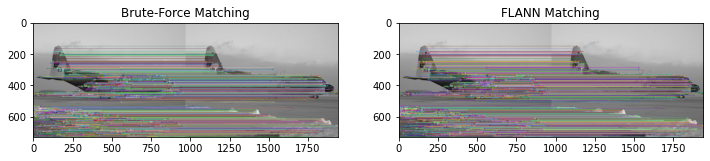

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load the image 
img1 = cv2.imread('c130.jpg', 0)  # Image to search in
img2 = cv2.imread('c130.jpg', 0)  # Use the same image for illustration

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# --- 1. Brute-Force Matching ---
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test (filter out potentially incorrect matches)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])

# Draw matches
img_matches_bf = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)

# -- 2. FLANN based Matching --
FLANN_INDEX_KDTREE = 1  
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:  # May need to adjust the threshold
        good_matches.append([m])

# Draw matches
img_matches_flann = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)


# Display results
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(img_matches_bf), plt.title('Brute-Force Matching')
plt.subplot(122), plt.imshow(img_matches_flann), plt.title('FLANN Matching')
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_frame(frame, background_gray, backSub):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # --- 1. Simple Frame Differencing ---
    diff = cv2.absdiff(gray, background_gray)
    _, mask_diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # --- 2. BackgroundSubtractorMOG2 ---
    mask_mog2 = backSub.apply(frame)

    return mask_diff, mask_mog2

# Load the image
image = cv2.imread('c130.jpg')  

# Check if the image opened successfully
if image is None:
    print("Error opening image. Check the path or file format.")
    exit()

background_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
backSub = cv2.createBackgroundSubtractorMOG2()

# Process the image (we'll do this just once)
mask_diff, mask_mog2 = process_frame(image, background_gray, backSub)

# Display the results
cv2.imshow('Original', image)
cv2.imshow('Frame Differencing Mask', mask_diff)
cv2.imshow('MOG2 Mask', mask_mog2)

cv2.waitKey(0)  # Wait indefinitely for a key press
cv2.destroyAllWindows()


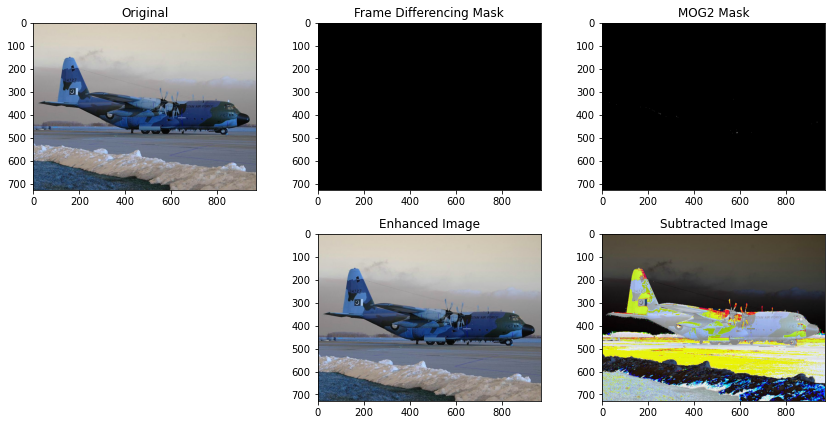

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_frame(frame, background_gray, backSub):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # --- 1. Simple Frame Differencing ---
    diff = cv2.absdiff(gray, background_gray)
    _, mask_diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # --- 2. BackgroundSubtractorMOG2 ---
    mask_mog2 = backSub.apply(frame)

    return mask_diff, mask_mog2

# Load the image
image = cv2.imread('c130.jpg')

# Check if the image opened successfully
if image is None:
    print("Error opening image. Check the path or file format.")
    exit()

# Background modeling
background_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
backSub = cv2.createBackgroundSubtractorMOG2()
mask_diff, mask_mog2 = process_frame(image, background_gray, backSub)

# C130 enhancement and subtraction
enhanced_image = image.copy()  # Create a copy to avoid modifying the original

# (Enhancement logic - you'll need to define how you want to enhance based on the mask)
# Example: Increase brightness where the mask_mog2 is white (foreground)
enhanced_image[mask_mog2 == 255] += 50  

# Subtract 130
subtracted_image = image - 130 
subtracted_image = np.clip(subtracted_image, 0, 255).astype(np.uint8)  # Ensure values stay within 0-255

# Visualization with matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(231), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.subplot(232), plt.imshow(mask_diff, cmap='gray'), plt.title('Frame Differencing Mask')
plt.subplot(233), plt.imshow(mask_mog2, cmap='gray'), plt.title('MOG2 Mask')
plt.subplot(235), plt.imshow(enhanced_image, cmap='gray'), plt.title('Enhanced Image')
plt.subplot(236), plt.imshow(subtracted_image, cmap='gray'), plt.title('Subtracted Image')

plt.tight_layout()
plt.show()


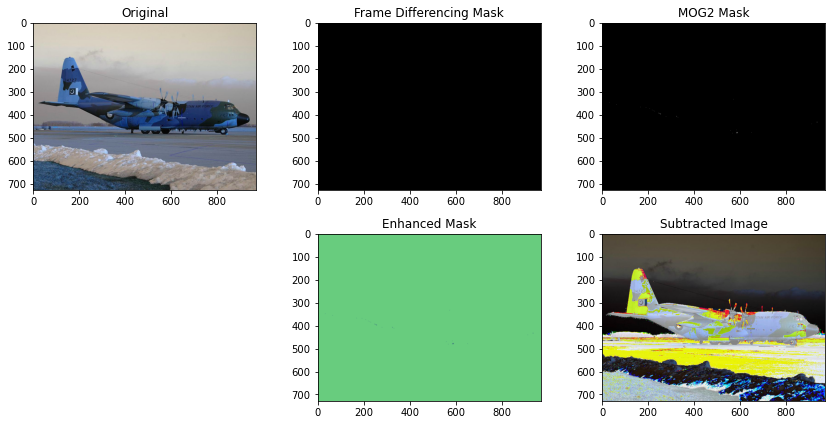

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_frame(frame, background_gray, backSub):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # --- 1. Simple Frame Differencing ---
    diff = cv2.absdiff(gray, background_gray)
    _, mask_diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # --- 2. BackgroundSubtractorMOG2 ---
    mask_mog2 = backSub.apply(frame)

    return mask_diff, mask_mog2

# Load the image
image = cv2.imread('c130.jpg') 

# Check if the image opened successfully
if image is None:
    print("Error opening image. Check the path or file format.")
    exit()

# Background modeling (consider adaptive thresholding or color segmentation in mask_mog2)
background_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
backSub = cv2.createBackgroundSubtractorMOG2()
mask_diff, mask_mog2 = process_frame(image, background_gray, backSub)

# Enhancement (mask visualization and adjust the threshold if needed)
color_mask = cv2.applyColorMap(mask_mog2, cv2.COLORMAP_JET)  # Apply colormap for visualization

# Example: Slightly reduce brightness in foreground regions (optional)
color_mask[color_mask > 128] =  (color_mask[color_mask > 128] * 0.8).astype(np.uint8)

# Subtract 130
subtracted_image = image - 130
subtracted_image = np.clip(subtracted_image, 0, 255).astype(np.uint8)

# Visualization with matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(231), plt.imshow(image), plt.title('Original')
plt.subplot(232), plt.imshow(mask_diff, cmap='gray'), plt.title('Frame Differencing Mask')
plt.subplot(233), plt.imshow(mask_mog2, cmap='gray'), plt.title('MOG2 Mask')
plt.subplot(235), plt.imshow(color_mask), plt.title('Enhanced Mask')
plt.subplot(236), plt.imshow(subtracted_image), plt.title('Subtracted Image')

plt.tight_layout()
plt.show()


<ipython-input-16-c31972f67b0b>:61: RuntimeWarning: invalid value encountered in divide
  gaussian_weights /= np.sum(gaussian_weights, axis=(0, 1), keepdims=True)
<ipython-input-16-c31972f67b0b>:67: RuntimeWarning: invalid value encountered in cast
  filtered_image[i - pad_amount, j - pad_amount] = filtered_pixel


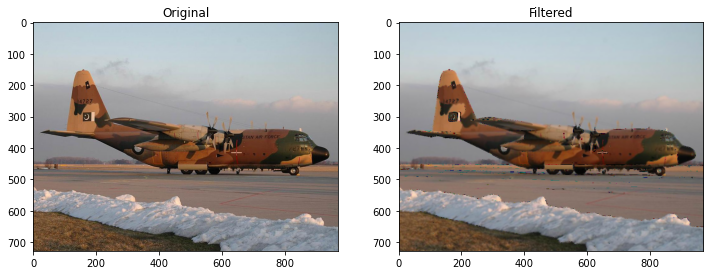

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adaptive_gaussian_filter(image, kernel_size=3, sigma_space=3, sigma_color=0.1):
    """Applies adaptive Gaussian filtering to an image.

    Args:
        image: The input image (BGR or grayscale).
        kernel_size: The size of the Gaussian kernel (odd number).
        sigma_space: Standard deviation in the spatial domain.
        sigma_color: Standard deviation in the color/intensity domain.

    Returns:
        The filtered image.
    """

    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  

    # Pad the image for boundary handling
    pad_amount = kernel_size // 2
    padded_image = cv2.copyMakeBorder(image, pad_amount, pad_amount, pad_amount, pad_amount, 
                                      cv2.BORDER_REFLECT_101)

    filtered_image = np.zeros_like(image)

    # Apply filtering to each pixel
    for i in range(pad_amount, padded_image.shape[0] - pad_amount):
        for j in range(pad_amount, padded_image.shape[1] - pad_amount):
            window = padded_image[i - pad_amount:i + pad_amount + 1, 
                                  j - pad_amount:j + pad_amount + 1]

            # Calculate local mean and standard deviation
            local_mean = np.mean(window)
            local_std = np.std(window)

            # Calculate per-channel local means 
            local_mean_array = np.mean(window, axis=(0, 1))  

            # Correctly reshape local_mean_array for broadcasting
            # This creates a (1, 1, 3) array which can be broadcasted across the window's spatial dimensions
            local_mean_array = local_mean_array.reshape(1, 1, 3)

            # Ensure that (sigma_space ** 2 + local_std ** 2) has the same shape as window for broadcasting
            denominator_space = np.full(window.shape[:2], sigma_space ** 2 + local_std ** 2)

            # Replicate the spatial denominator for each color channel
            denominator_space_broadcasted = np.repeat(denominator_space[:, :, np.newaxis], 3, axis=2)

            # Calculate Gaussian weights with adaptive sigma for spatial component
            gaussian_weights_spatial = np.exp(-0.5 * (np.square(window - local_mean_array) / denominator_space_broadcasted))

            # Calculate Gaussian weights for color component
            gaussian_weights_color = np.exp(-0.5 * (np.square(window - local_mean_array) / (sigma_color ** 2)))

            # Combine spatial and color weights
            gaussian_weights = gaussian_weights_spatial * gaussian_weights_color

            # Normalize weights
            gaussian_weights /= np.sum(gaussian_weights, axis=(0, 1), keepdims=True)

            # Apply weights to calculate the filtered pixel value
            filtered_pixel = np.sum(window * gaussian_weights, axis=(0, 1))

            # Set the filtered pixel value in the output image
            filtered_image[i - pad_amount, j - pad_amount] = filtered_pixel

#             filtered_image[i - pad_amount, j - pad_amount] = np.sum(window * gaussian_weights, axis=(0, 1))

    return filtered_image

# Load the image (make sure to replace with your image path)
image = cv2.imread('c130.jpg')

# Apply the adaptive Gaussian filter
filtered_image = adaptive_gaussian_filter(image, kernel_size=5, sigma_space=5, sigma_color=0.2)

# Display the original and filtered images
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(122), plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)), plt.title('Filtered')
plt.show()

